In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Importando Bibliotecas**

In [4]:
import re
import subprocess
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#**Preparando os dados**

In [5]:

#Script para extrair notas e textos de reviews


def ler_docx(caminho_arquivo):

    try:
        resultado = subprocess.run(
            ['pandoc', caminho_arquivo, '-t', 'plain'],
            capture_output=True,
            text=True,
            check=True
        )
        return resultado.stdout
    except subprocess.CalledProcessError as e:
        print(f"Erro ao ler o arquivo: {e}")
        sys.exit(1)

def extrair_reviews(texto):
    """
    Extrai todas as reviews do texto usando regex
    Retorna uma lista de tuplas (texto_review, nota)
    """
    # Pattern para capturar
    pattern = r'(\d+)\s*/10\s*(.*?)\s*Helpful'

    # re.DOTALL faz o . capturar também quebras de linha
    matches = re.findall(pattern, texto, re.DOTALL)

    reviews = []
    for match in matches:
        nota = int(match[0])
        texto_review = match[1].strip()
        # Limpa espaços extras e quebras de linha múltiplas
        texto_review = re.sub(r'\n{3,}', '\n\n', texto_review)
        reviews.append((texto_review, nota))

    return reviews

def criar_dataframe(reviews):
    """
    Cria um DataFrame pandas com as colunas, id, X (texto) e Y (nota)
    """
    df = pd.DataFrame(reviews, columns=['X', 'Y'])
    df.insert(0, 'id', range(1, len(df) + 1))
    return df

def main():

    caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/projeto 1 - data set.docx'

    # Ler o arquivo docx
    texto_completo = ler_docx(caminho_arquivo)

    # Extrair as reviews
    reviews = extrair_reviews(texto_completo)

    if not reviews:
        print("⚠️  Nenhuma review encontrada no formato esperado!")
        print("    Formato esperado: NOTA/10 ... TEXTO ... Helpful")
        return None

    # Criar DataFrame
    df = criar_dataframe(reviews)

    # Exibir resultados
    print(f"\n✅ {len(df)} reviews extraídas com sucesso!\n")
    print("=" * 60)
    print("RESUMO DOS DADOS:")
    print("=" * 60)
    print(f"\nDistribuição das notas:")
    print(df['Y'].value_counts().sort_index())
    print(f"\nEstatísticas:")
    print(df['Y'].describe())

    # Mostrar preview
    print("\n" + "=" * 60)
    print("PREVIEW DAS PRIMEIRAS 3 REVIEWS:")
    print("=" * 60)
    for i, row in df.head(3).iterrows():
        print(f"\n--- Review {i+1} ---")
        print(f"Nota (Y): {row['Y']}")
        print(f"Texto (X): {row['X'][:200]}..." if len(row['X']) > 200 else f"Texto (X): {row['X']}")

    # Salvar como CSV
    output_path = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/reviews_extraidas.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Dados salvos em: {output_path}")

    return df

if __name__ == "__main__":
    df = main()


✅ 544 reviews extraídas com sucesso!

RESUMO DOS DADOS:

Distribuição das notas:
Y
1     111
2      56
3      58
4      50
5      63
6      59
7      55
8      36
9      22
10     34
Name: count, dtype: int64

Estatísticas:
count    544.000000
mean       4.553309
std        2.800439
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       10.000000
Name: Y, dtype: float64

PREVIEW DAS PRIMEIRAS 3 REVIEWS:

--- Review 1 ---
Nota (Y): 6
Texto (X): Confusing and Confused Movie

Nicole Kidman is giving a performance in "Babygirl" that no doubt many
people will be calling "brave," mostly because it suggests that women
over the age of 50 (gasp!) li...

--- Review 2 ---
Nota (Y): 6
Texto (X): Spoilers: Took me a couple of days to understand the ending and the
twist

--- Review 3 ---
Nota (Y): 5
Texto (X): This Baby Has Some Growing Up To Do

A lot has been said about Babygirl, mostly involving Kidman's
performance. The remainder of chatter has been about the 

#**Separando os dados em Training e Test sets**

In [6]:

# Carrega o CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/reviews_extraidas.csv')

# 1-5 = Negativo (0)
# 6-10 = Positivo (1)
def categorizar(nota):
    if nota <= 5:
        return 0  # Negativo
    else:
        return 1  # Positivo

df['Y_categoria'] = df['Y'].apply(categorizar)

# Separa X (texto) e Y (CATEGORIA, não a nota original!)
X = df['X']
Y = df['Y_categoria']

print("=" * 50)
print("DISTRIBUIÇÃO DAS 3 CLASSES")
print("=" * 50)
print(f"Negativo (0): {(Y == 0).sum()}")
print(f"Positivo (1): {(Y == 1).sum()}")


# Divide em treino (80%) e teste (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# Mostra os resultados
print("\n" + "=" * 50)
print("DIVISÃO DOS DADOS")
print("=" * 50)
print(f"\nTotal de reviews: {len(df)}")
print(f"Training set: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:")
print("=" * 50)
print(Y_train.value_counts().sort_index())

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TEST SET:")
print("=" * 50)
print(Y_test.value_counts().sort_index())

DISTRIBUIÇÃO DAS 3 CLASSES
Negativo (0): 338
Positivo (1): 206

DIVISÃO DOS DADOS

Total de reviews: 544
Training set: 435 (80.0%)
Test set: 109 (20.0%)

DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:
Y_categoria
0    270
1    165
Name: count, dtype: int64

DISTRIBUIÇÃO DAS CLASSES NO TEST SET:
Y_categoria
0    68
1    41
Name: count, dtype: int64


#**Embeddings Word2Vec (VETORIZAÇÃO)**

In [8]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 76.3 MB/s eta 0:00:00


In [9]:
import gensim.downloader
import numpy as np

print("🔄 Carregando Word2Vec (pode demorar na primeira vez)...")
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
print("✅ Word2Vec carregado!")
print(f"📊 Dimensões do embedding: 300")

🔄 Carregando Word2Vec (pode demorar na primeira vez)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Word2Vec carregado!
📊 Dimensões do embedding: 300


In [19]:
def texto_para_embedding(texto, modelo, dim=300):
    """
    Converte texto em embedding (média dos vetores das palavras)
    """
    palavras = texto.lower().split()
    vetores = []

    for palavra in palavras:
        if palavra in modelo:
            vetores.append(modelo[palavra])

    if vetores:
        return np.mean(vetores, axis=0)
    else:
        return np.zeros(dim)

In [20]:
print("🔄 Gerando embeddings para o conjunto de treino...")
X_train_w2v = np.array([texto_para_embedding(texto, word2vec_model) for texto in X_train])
print(f"✅ Shape treino: {X_train_w2v.shape}")

print("🔄 Gerando embeddings para o conjunto de teste...")
X_test_w2v = np.array([texto_para_embedding(texto, word2vec_model) for texto in X_test])
print(f"✅ Shape teste: {X_test_w2v.shape}")

🔄 Gerando embeddings para o conjunto de treino...
✅ Shape treino: (435, 300)
🔄 Gerando embeddings para o conjunto de teste...
✅ Shape teste: (109, 300)


In [21]:
# Embedding do 1º exemplo de treino
v0 = X_train_w2v[0]

print(f"📊 Texto original (primeiros 200 chars):")
print(f"{X_train.iloc[0][:200]}...")

print(f"\n📊 Shape do embedding: {v0.shape}")
print(f"📊 Dimensões: {len(v0)}")

print(f"\n📊 Primeiros 20 valores do vetor:")
print(v0[:20])

print(f"\n📊 Estatísticas do vetor:")
print(f"   Mínimo: {v0.min():.4f}")
print(f"   Máximo: {v0.max():.4f}")
print(f"   Média:  {v0.mean():.4f}")
print(f"   Std:    {v0.std():.4f}")

📊 Texto original (primeiros 200 chars):
So bad it makes wanna scream

Everyone praises performances, script and atmosphere, but truth be told
they are the very thing that's trash about this movie. Erotic thriller.
There is something somewha...

📊 Shape do embedding: (300,)
📊 Dimensões: 300

📊 Primeiros 20 valores do vetor:
[ 0.05071654  0.0168731   0.03875153  0.08129657 -0.09665395  0.0406131
  0.06145449 -0.04558436  0.06718996  0.06010112 -0.04550383 -0.1344613
 -0.01976578 -0.00031547 -0.09628692  0.11483765  0.03987772  0.09870303
 -0.0121337  -0.05740695]

📊 Estatísticas do vetor:
   Mínimo: -0.1345
   Máximo: 0.1613
   Média:  0.0007
   Std:    0.0516


In [22]:
import numpy as np

texto = X_train.iloc[0]
palavras = texto.lower().split()

print(f"📊 Texto original (primeiros 200 chars):")
print(f"{texto[:200]}...\n")

# Palavras encontradas no Word2Vec
palavras_encontradas = [p for p in palavras if p in word2vec_model]

print(f"✅ Palavras encontradas no Word2Vec: {len(palavras_encontradas)}/{len(palavras)}")
print(f"\n📊 Primeiras 20 palavras com embeddings:")
for i, palavra in enumerate(palavras_encontradas[:20]):
    vetor = word2vec_model[palavra]
    print(f"  {palavra}: [{vetor[0]:.3f}, {vetor[1]:.3f}, {vetor[2]:.3f}, ...] (média: {vetor.mean():.4f})")

📊 Texto original (primeiros 200 chars):
So bad it makes wanna scream

Everyone praises performances, script and atmosphere, but truth be told
they are the very thing that's trash about this movie. Erotic thriller.
There is something somewha...

✅ Palavras encontradas no Word2Vec: 108/139

📊 Primeiras 20 palavras com embeddings:
  so: [-0.057, -0.031, -0.006, ...] (média: 0.0007)
  bad: [0.063, 0.125, 0.113, ...] (média: -0.0039)
  it: [0.084, -0.000, 0.053, ...] (média: -0.0043)
  makes: [0.036, -0.024, 0.138, ...] (média: 0.0041)
  wanna: [0.073, -0.006, 0.134, ...] (média: -0.0004)
  scream: [0.183, -0.256, 0.051, ...] (média: -0.0065)
  everyone: [0.074, -0.165, -0.108, ...] (média: -0.0130)
  praises: [0.061, 0.424, -0.083, ...] (média: -0.0012)
  script: [0.085, -0.032, -0.053, ...] (média: -0.0024)
  but: [-0.048, 0.082, 0.046, ...] (média: 0.0001)
  truth: [0.287, -0.146, 0.188, ...] (média: 0.0116)
  be: [-0.229, -0.088, 0.128, ...] (média: 0.0043)
  told: [-0.042, -0.002, 0.06

In [24]:
# Testar com palavras que fazem sentido
print("🔍 Similaridade entre palavras:")
print(f"  good - bad: {word2vec_model.similarity('good', 'bad'):.4f}")
print(f"  good - excellent: {word2vec_model.similarity('good', 'excellent'):.4f}")
print(f"  movie - film: {word2vec_model.similarity('movie', 'film'):.4f}")
print(f"  terrible - awful: {word2vec_model.similarity('terrible', 'awful'):.4f}")

print("\n🔍 Palavras mais similares a 'good':")
for palavra, sim in word2vec_model.most_similar('good', topn=5):
    print(f"  {palavra}: {sim:.4f}")

print("\n🔍 Palavras mais similares a 'terrible':")
for palavra, sim in word2vec_model.most_similar('terrible', topn=5):
    print(f"  {palavra}: {sim:.4f}")

🔍 Similaridade entre palavras:
  good - bad: 0.7190
  good - excellent: 0.6443
  movie - film: 0.8677
  terrible - awful: 0.7479

🔍 Palavras mais similares a 'good':
  great: 0.7292
  bad: 0.7190
  terrific: 0.6889
  decent: 0.6837
  nice: 0.6836

🔍 Palavras mais similares a 'terrible':
  horrible: 0.9244
  horrendous: 0.8467
  dreadful: 0.8023
  awful: 0.7479
  horrid: 0.7179


#**TREINAR SVM**

In [25]:
# Treinar SVM
print("🔄 Treinando SVM...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

svm_model.fit(X_train_w2v, Y_train)
print("✅ Modelo treinado!")

🔄 Treinando SVM...
✅ Modelo treinado!


#**FAZER PREDIÇÕES**

In [26]:
Y_pred = svm_model.predict(X_test_w2v)

#**AVALIAR RESULTADOS**

In [27]:
# Resultados
print("\n" + "=" * 60)
print("📈 RESULTADOS - SVM + Word2Vec (Binário)")
print("=" * 60)

accuracy = accuracy_score(Y_test, Y_pred)
f1_macro = f1_score(Y_test, Y_pred, average='macro')
f1_weighted = f1_score(Y_test, Y_pred, average='weighted')

print(f"\n🎯 Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 F1-Score (macro): {f1_macro:.4f}")
print(f"🎯 F1-Score (weighted): {f1_weighted:.4f}")

print("\n📋 CLASSIFICATION REPORT")
print(classification_report(Y_test, Y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de Confusão
cm = confusion_matrix(Y_test, Y_pred)
print("📊 MATRIZ DE CONFUSÃO")
print(cm)


📈 RESULTADOS - SVM + Word2Vec (Binário)

🎯 Acurácia: 0.7156 (71.56%)
🎯 F1-Score (macro): 0.6136
🎯 F1-Score (weighted): 0.6628

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negativo       0.69      0.99      0.81        68
    Positivo       0.92      0.27      0.42        41

    accuracy                           0.72       109
   macro avg       0.80      0.63      0.61       109
weighted avg       0.78      0.72      0.66       109

📊 MATRIZ DE CONFUSÃO
[[67  1]
 [30 11]]


#**VISUALIZAÇÃO**

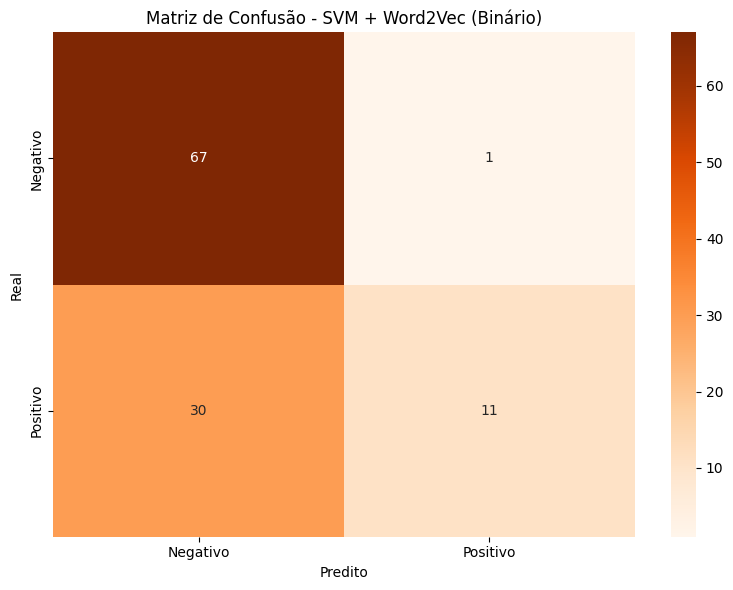

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - SVM + Word2Vec (Binário)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

#**Treinamento Classes Balanceadas**

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# SVM com classes balanceadas
print("🔄 Treinando SVM com class_weight='balanced'...")

svm_model_balanced = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',  # ← Dá mais peso à classe minoritária
    random_state=42
)

svm_model_balanced.fit(X_train_w2v, Y_train)
print("✅ Modelo treinado!")





🔄 Treinando SVM com class_weight='balanced'...
✅ Modelo treinado!


In [32]:
# Predições
Y_pred_balanced = svm_model_balanced.predict(X_test_w2v)

In [33]:
# Resultados
print("\n" + "=" * 60)
print("📈 RESULTADOS - SVM + Word2Vec (Balanceado)")
print("=" * 60)

accuracy = accuracy_score(Y_test, Y_pred_balanced)
f1_macro = f1_score(Y_test, Y_pred_balanced, average='macro')
f1_weighted = f1_score(Y_test, Y_pred_balanced, average='weighted')

print(f"\n🎯 Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 F1-Score (macro): {f1_macro:.4f}")
print(f"🎯 F1-Score (weighted): {f1_weighted:.4f}")

print("\n📋 CLASSIFICATION REPORT")
print(classification_report(Y_test, Y_pred_balanced, target_names=['Negativo', 'Positivo']))

# Matriz de Confusão
cm = confusion_matrix(Y_test, Y_pred_balanced)
print("📊 MATRIZ DE CONFUSÃO")
print(cm)



📈 RESULTADOS - SVM + Word2Vec (Balanceado)

🎯 Acurácia: 0.7890 (78.90%)
🎯 F1-Score (macro): 0.7816
🎯 F1-Score (weighted): 0.7916

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negativo       0.87      0.78      0.82        68
    Positivo       0.69      0.80      0.74        41

    accuracy                           0.79       109
   macro avg       0.78      0.79      0.78       109
weighted avg       0.80      0.79      0.79       109

📊 MATRIZ DE CONFUSÃO
[[53 15]
 [ 8 33]]


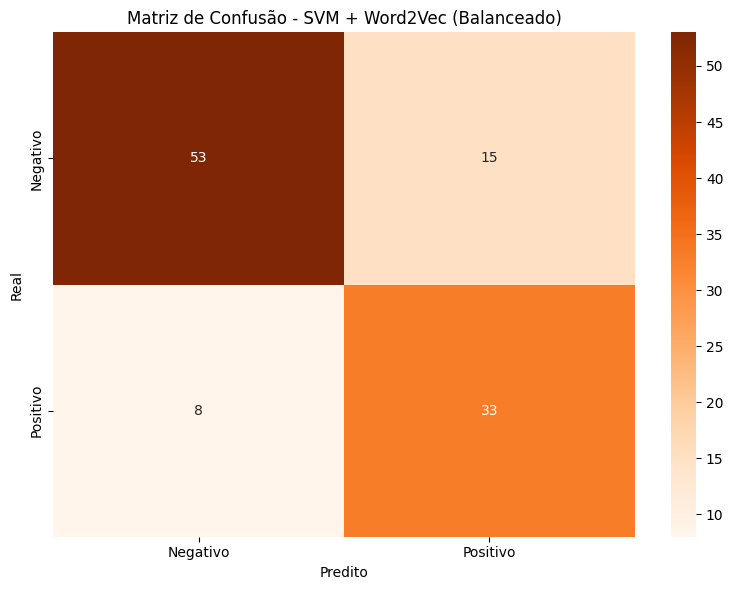

In [35]:
# Visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão - SVM + Word2Vec (Balanceado)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [36]:
novas_reviews = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either."
]

# Converter para embeddings Word2Vec
novas_reviews_w2v = np.array([texto_para_embedding(texto, word2vec_model) for texto in novas_reviews])

# Predições com o modelo balanceado
predicoes = svm_model_balanced.predict(novas_reviews_w2v)

# Mapear 0/1 para nomes
classe_nome = {0: 'Negativo', 1: 'Positivo'}

print("=" * 60)
print("🔮 PREDIÇÕES - SVM + Word2Vec")
print("=" * 60)

for review, pred in zip(novas_reviews, predicoes):
    print(f"\nReview: {review}")
    print(f"Classe predita: {pred} ({classe_nome[pred]})")

🔮 PREDIÇÕES - SVM + Word2Vec

Review: This movie was absolutely amazing! I loved every moment of it.
Classe predita: 0 (Negativo)

Review: Terrible film. Waste of time and money. Do not watch.
Classe predita: 0 (Negativo)

Review: It was okay, nothing special but not bad either.
Classe predita: 0 (Negativo)
